In [1]:
import sys
sys.path.append('../')

import tquant as tq

from datetime import date, timedelta
import tensorflow as tf
# import pandas as pd
from datastore import *

# Settings

In [2]:
tq.Settings.evaluation_date = date(2024, 4, 30)

calendar = tq.TARGET()
daycounter = tq.DayCounter(tq.DayCounterConvention.Actual360)
evaluation_date = tq.Settings.evaluation_date

# Market

In [3]:
rates = ir_eur_curve_estr['quote'].values
times = ir_eur_curve_estr['daycount'].values/365

rates_6m = ir_eur_curve_6m['quote'].values
times_6m = ir_eur_curve_6m['daycount'].values/365 # sono sbagliati questi

market_data = {}
market_data["EUR:ESTR"] = tq.RateCurve(times, rates, 'LINEAR')
market_data["EUR:6M"] = tq.RateCurve(times, rates, 'LINEAR')#tq.RateCurve(times_6m, rates_6m, 'LINEAR')


# Swap

In [4]:
currency = tq.Currency.EUR
mod_fol_convention = tq.BusinessDayConvention.ModifiedFollowing
daycount_fix = tq.DayCounterConvention.Actual360
daycount_flt = tq.DayCounterConvention.Actual360

# --------------
# fixed leg
# start_date = date(2015,12,31)
# end_date = calendar.advance(start_date, 25, tq.TimeUnit.Years, mod_fol_convention) #25 years

eur6m_index = tq.IborIndex(calendar, 6, tq.TimeUnit.Months, tq.Currency.EUR)
irs_eur6m_generator = tq.SwapGenerator(currency, 2, "1Y", "6M", mod_fol_convention, 100e6, daycount_fix, daycount_flt, calendar, eur6m_index)

In [5]:
fixed_rate = 0.01
swap = irs_eur6m_generator.build(evaluation_date, fixed_rate, "10Y")

In [6]:
swap_engine = tq.SwapPricer(curve_map) # perché  non va in errore se non trova il fixing??
npv_swap = swap_engine.price(swap, evaluation_date, market_data)

print(f"NPV FixedLeg: {swap_engine.pv_fix :,.0f}")
print(f"NPV FloatingLeg: {swap_engine.pv_flt :,.0f}")
########
print(f"NPV Swap: {npv_swap :,.0f}")

NPV FixedLeg: 8,716,366
NPV FloatingLeg: 24,053,323
NPV Swap: 15,336,956


In [7]:
npv_swap, tape = swap_engine.price_aad(swap, evaluation_date, market_data)
sensitivities = tape.gradient(npv_swap, [market_data['EUR:ESTR'].rates, market_data['EUR:6M'].rates])

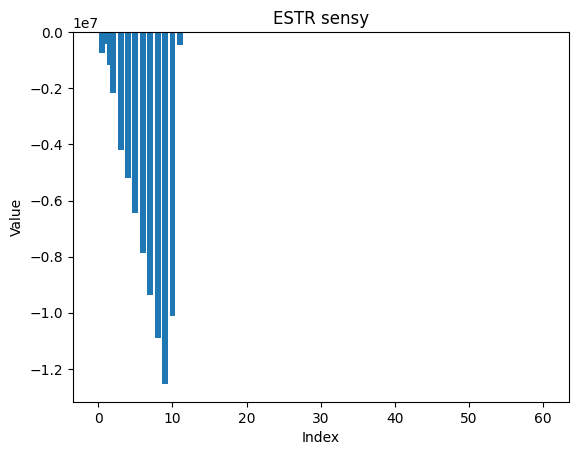

In [10]:
# Function to extract values from TensorFlow tensors
def extract_value(x):
    if isinstance(x, tf.Tensor):
        return x.numpy()  # Extract value from TensorFlow tensor
    else:
        return x
    
sensy_estr = pd.DataFrame([market_data['EUR:ESTR'].pillars.tolist(), sensitivities[0]]).T
sensy_estr.columns = ['time', 'sensy_estr']
sensy_estr.fillna(0, inplace = True)
sensy_estr.set_index('time', inplace = True)
sensy_estr['sensy_estr'] = sensy_estr['sensy_estr'].apply(extract_value)

sensy_eur6m = pd.DataFrame([market_data['EUR:6M'].pillars.tolist(), sensitivities[1]]).T
sensy_eur6m.columns = ['time', 'sensy_eur6m']
sensy_eur6m.fillna(0, inplace = True)
sensy_eur6m.set_index('time', inplace = True)
sensy_eur6m['sensy_eur6m'] = sensy_eur6m['sensy_eur6m'].apply(extract_value)

import matplotlib.pyplot as plt
# Plot line chart of column 'A'
# plt.bar(sensy_eur6m.index, sensy_eur6m['sensy_eur6m'])
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('EUR 6M sensy')
# plt.show()

# Plot line chart of column 'A'
plt.bar(sensy_estr.index, sensy_estr['sensy_estr'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('ESTR sensy')
plt.show()

# debug vs quantlib

In [11]:
import QuantLib as ql
calendar_ql = ql.TARGET()


def get_ql_curve(curve_tq, evaluation_date):
    evaluation_date_ql = ql.Date.from_date(evaluation_date)
    pillar_taus = [int(np.round(x,0)) for x in curve_tq.pillars*365]
    dates_ql = [evaluation_date_ql + d for d in pillar_taus]
    rates_ql = [r.numpy() for r in curve_tq.rates]
    curve_ql = ql.ZeroCurve(dates_ql, rates_ql, ql.ActualActual(ql.ActualActual.ISDA), ql.TARGET())
    curve_ql.enableExtrapolation()
    return curve_ql

In [61]:
estr_ql = get_ql_curve(market_data['EUR:ESTR'], evaluation_date)
eur6m_ql = get_ql_curve(market_data['EUR:6M'], evaluation_date)
handleYieldTermStructure = ql.YieldTermStructureHandle(eur6m_ql)
index_ql = ql.Euribor6M(handleYieldTermStructure)
ql.Settings.instance().evaluationDate = ql.Date.from_date(evaluation_date)

In [74]:
start_date_ql = ql.Date.from_date(swap.start_date) +2
end_date_ql = ql.Date.from_date(swap.maturity)
fix_schedule_ql = ql.MakeSchedule(start_date_ql, end_date_ql, ql.Period('1Y'))
flt_schedule_ql = ql.MakeSchedule(start_date_ql, end_date_ql, ql.Period('6M'))
gearing = swap._gearings
spread = swap._margins
rates_swap = swap._rates
fixed_daycount = ql.Actual360()
flt_daycount = ql.Actual360()

swap_ql = ql.NonstandardSwap(type = ql.VanillaSwap.Payer, fixedNominal=swap._fix_notionals, floatingNominal=swap._float_notionals,
                   fixedSchedule=fix_schedule_ql, floatSchedule=flt_schedule_ql, fixedRate=rates_swap, gearing=gearing, spread=spread,
                   index=index_ql, fixedDayCount=fixed_daycount, floatDayCount=flt_daycount)
engine = ql.DiscountingSwapEngine(handleYieldTermStructure)

swap_ql.setPricingEngine(engine)
print(f"NPV Swap: {swap_ql.NPV() :,.0f}")
print(20*"*")
# print(f"NPV FixedLeg: {swap_ql.fixedLegNPV() :,.0f}")
# print(f"NPV FloatingLeg: {swap_ql.floatingLegNPV() :,.0f}")

NPV Swap: 14,990,353
********************


In [85]:
def makeVanillaSwap(start, maturity, nominal, fixedRate, index, typ=ql.VanillaSwap.Payer):
    end = maturity# ql.TARGET().advance(start, maturity)
    fixedLegTenor = ql.Period("12M")
    fixedLegBDC = ql.ModifiedFollowing
    fixedLegDC = ql.Thirty360(ql.Thirty360.BondBasis)
    spread = 0.0
    fixedSchedule = ql.Schedule(start,
                                end, 
                                fixedLegTenor, 
                                index.fixingCalendar(), 
                                fixedLegBDC,
                                fixedLegBDC, 
                                ql.DateGeneration.Backward,
                                False)
    floatSchedule = ql.Schedule(start,
                                end,
                                index.tenor(),
                                index.fixingCalendar(),
                                index.businessDayConvention(),
                                index.businessDayConvention(),
                                ql.DateGeneration.Backward,
                                False)
    swap = ql.VanillaSwap(typ, 
                          nominal,
                          fixedSchedule,
                          fixedRate,
                          fixedLegDC,
                          floatSchedule,
                          index,
                          spread,
                          index.dayCounter())
    return swap

In [93]:
swap_ql2 = makeVanillaSwap(start_date_ql, end_date_ql, swap.notional, swap.quote, index_ql )
swap_ql2.setPricingEngine(engine)
print(f"NPV QL Swap: {swap_ql2.NPV() :,.0f}")
print(f"NPV TQ Swap: {npv_swap :,.0f}")
print(20*"*")
print(f"NPV QL FixedLeg: {swap_ql2.fixedLegNPV() :,.0f}")
print(f"NPV TQ FixedLeg: {swap_engine.pv_fix :,.0f}")
print(f"NPV QL FloatingLeg: {swap_ql2.floatingLegNPV() :,.0f}")
print(f"NPV TQ FloatingLeg: {swap_engine.pv_flt :,.0f}")

NPV QL Swap: 15,110,528
NPV TQ Swap: 15,336,956
********************
NPV QL FixedLeg: -8,603,777
NPV TQ FixedLeg: 8,716,366
NPV QL FloatingLeg: 23,714,305
NPV TQ FloatingLeg: 24,053,323


# Tensor Pricing 

## simulate random 1M curves

In [14]:
# instance of the hull-white model for 1M curve simulation
mean_rev = 0.02
sigma = 0.045
hw = tq.HullWhiteProcess(mean_rev, sigma, market_curve=estr_curve)
hw_kernel = tq.GaussianRateKernel1D(hw)

# simulate short rate and discount curve 
paths = int(1e6) 
r_tensor, zb_tensor, grid = hw_kernel.rate_tensor(paths,
                                                  last_grid_time=1,
                                                  time_steps=2) # evaluation_date + 1y
# Reshape the tensor and create a discount curve object
reshaped_tensor = tf.reshape(zb_tensor, shape=(zb_tensor.shape[1], paths, 1))
rate_curve_tensor = tq.DiscountCurveSimple(times, reshaped_tensor)

## swap price for 1M simulated curves

In [15]:
npv_swap = swap_engine.price(rate_curve_tensor, rate_curve_tensor, evaluation_date)

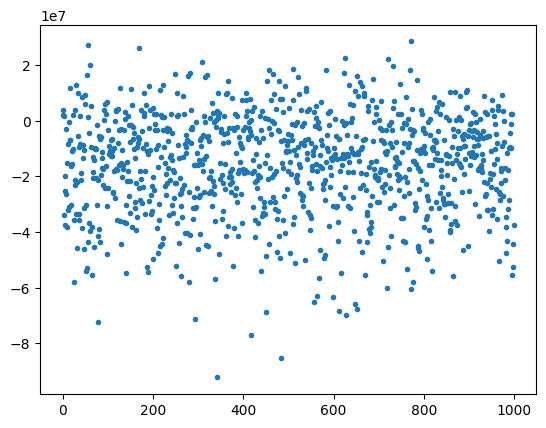

In [16]:
plt.plot(npv_swap[:1000], '.');